In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import magrec.image_processing.Masks as masks
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation
from magrec.transformation.MagneticFields import MagneticFields   

from magrec.misc.plot import plot_n_components
from magrec.misc.data import Data
from magrec import __datapath__

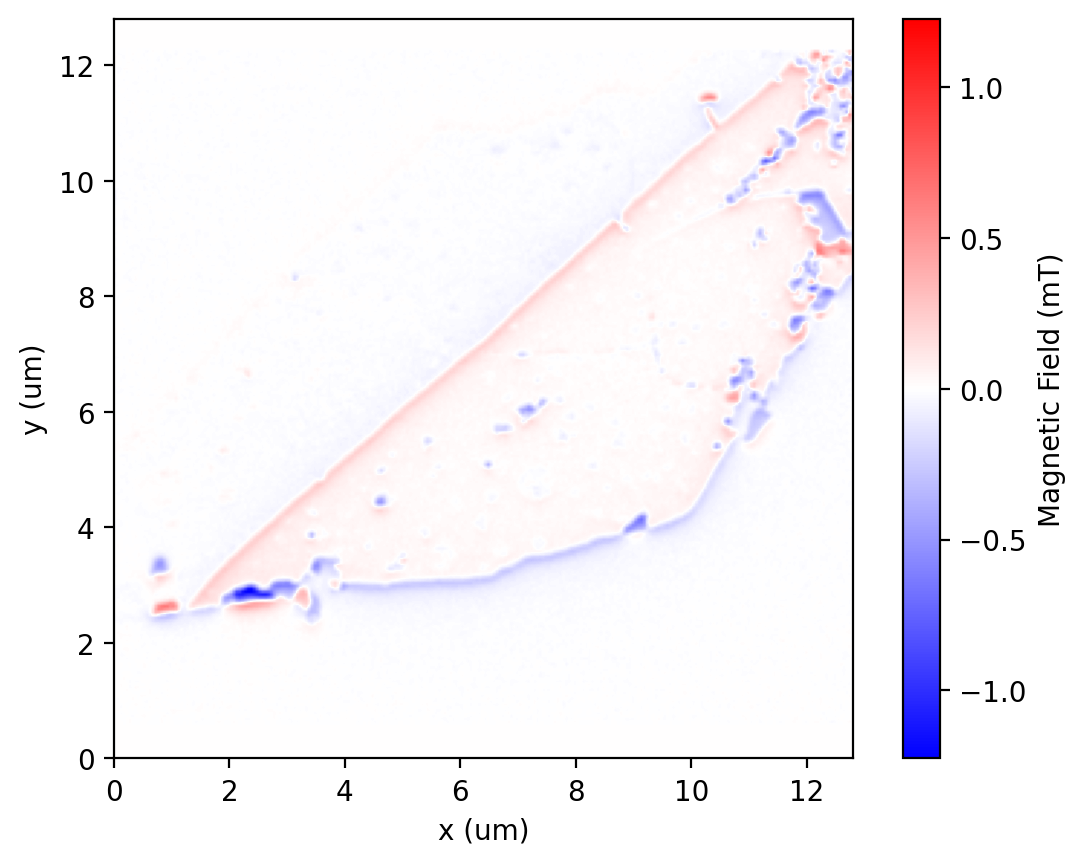

In [20]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

sensor_theta = 56
sensor_phi = 191
height = 0.035

dataset = Data()
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.add_hanning_filter(0.05)
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()

dataset.plot_target()

In [21]:
# Reconstruct Bxyz
dataset.set_transformer(MagneticFields)
dataset.transform_data()

# Defining a wieght mask for fitting

## Now we will try to reconstruct the magnetisation using a neural network.

Spatial filter implemented into the model with a width of 0.04 and 0.04 pixels or 0.00 um.
Number of sources: 1
Number of targets: 1


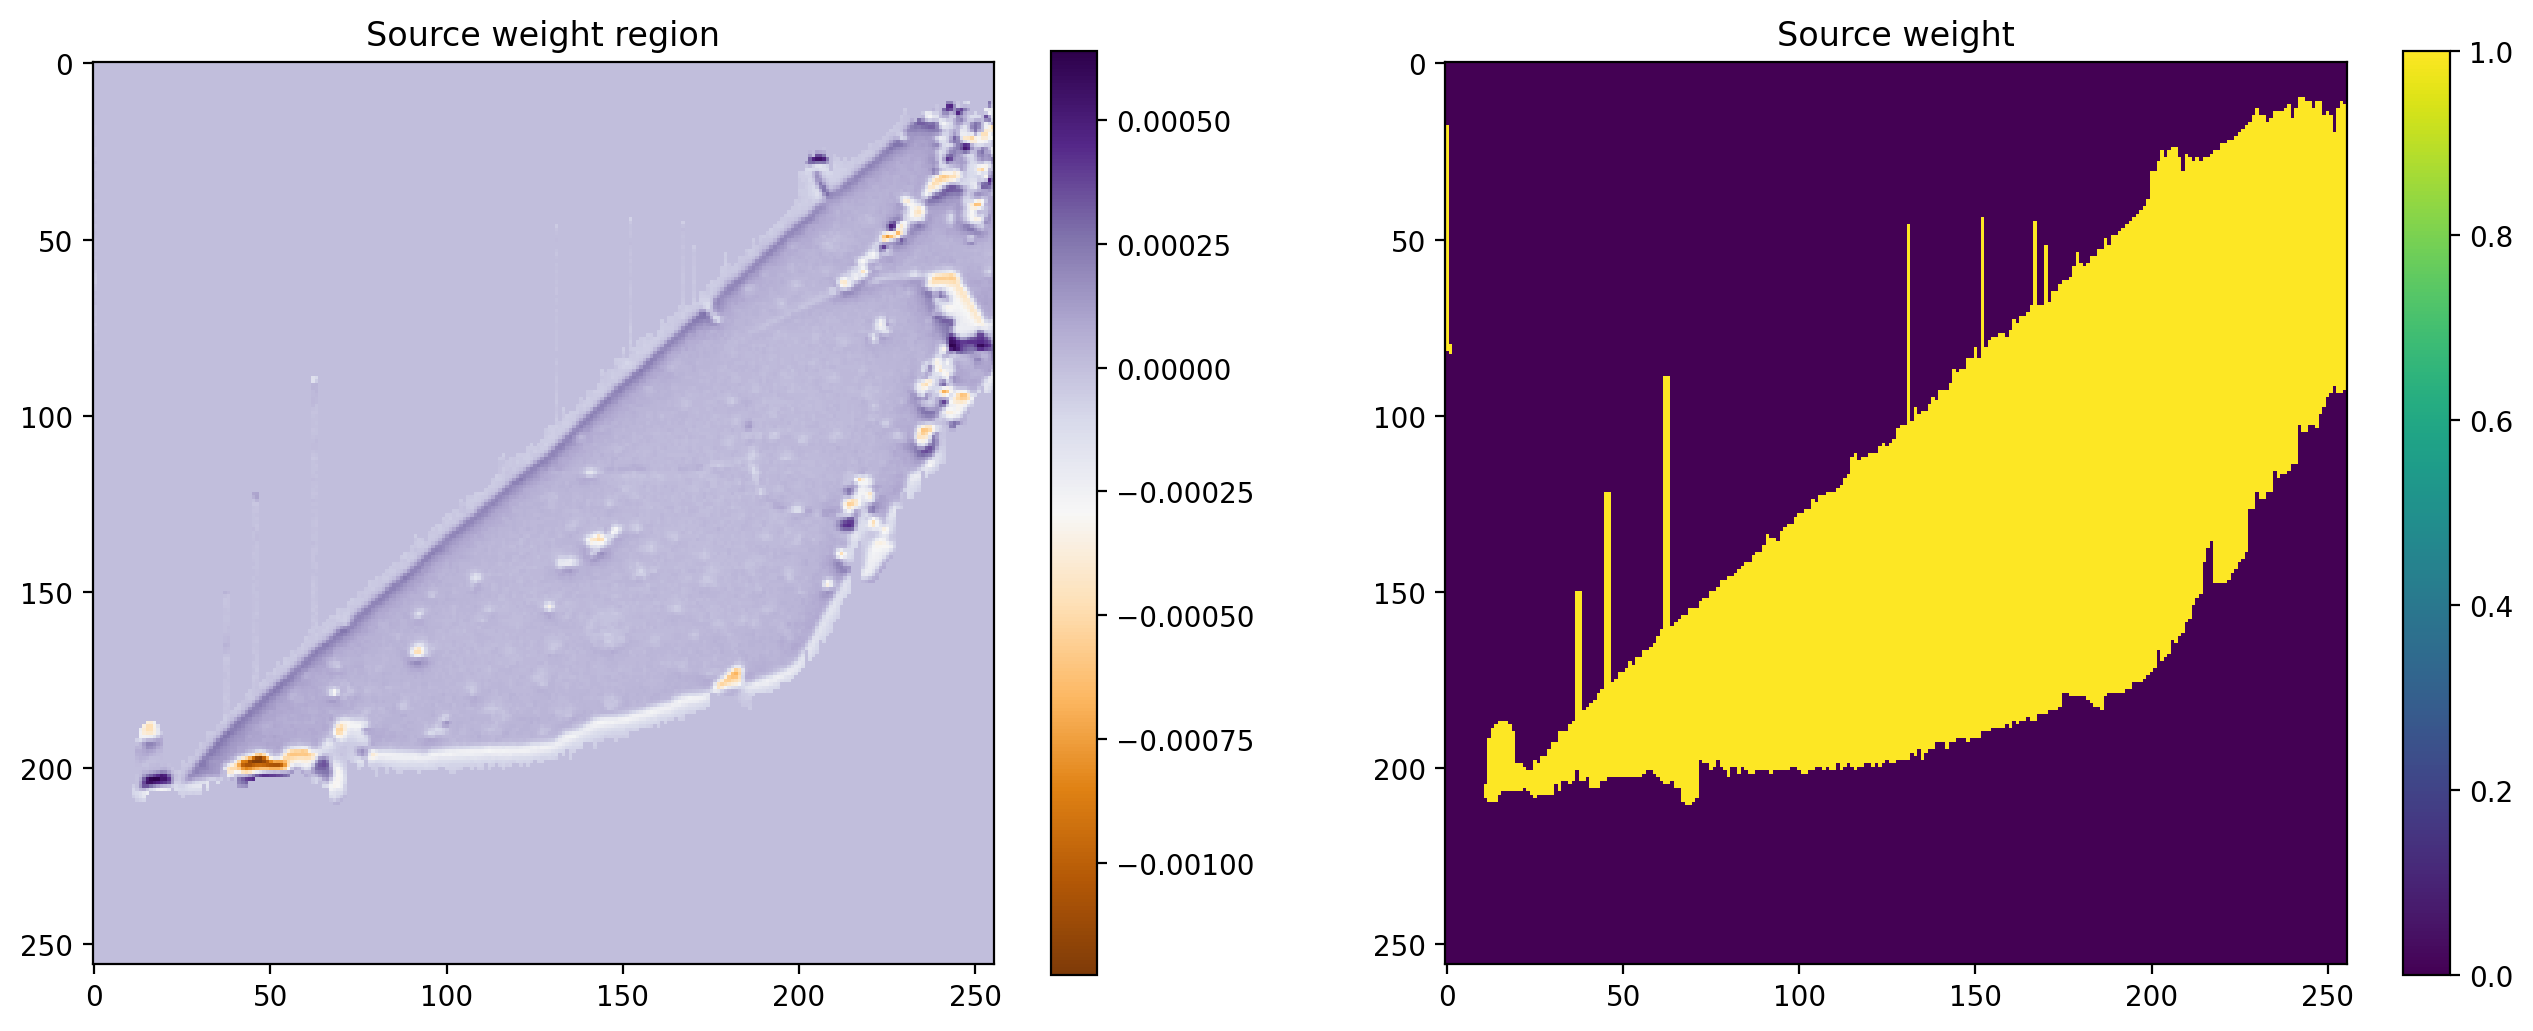

In [27]:

# Deifne the source weight
threshold = 0.8e-4
source_weight = masks.mask_vert_dir(dataset.transformed_target[2,::], threshold, plot = True)

nn_dataset = Data()
sensor_theta = 0
sensor_phi = 0
nn_dataset.load_data(dataset.transformed_target[2,::], dx, dy, height, sensor_theta, sensor_phi, 0)

Model = UniformMagnetisation(dataset, 
                            loss_type = "MSE",  
                            scaling_factor = 1e6,
                            m_theta = 0, 
                            m_phi = 0,             
                            source_weight = source_weight,
                            loss_weight = None, 
                            spatial_filter = False, 
                            spatial_filter_type = "Hanning",
                            spatial_filter_width = [height, height])


Model.plot_weights()
FittingMethod = CNN(Model, learning_rate=0.1)


In [32]:
FittingMethod.fit(n_epochs=501)

epoch     1 | loss on last mini-batch:  7.30e+02
epoch    11 | loss on last mini-batch:  6.91e+02
epoch    21 | loss on last mini-batch:  6.57e+02
epoch    31 | loss on last mini-batch:  7.11e+02
epoch    41 | loss on last mini-batch:  6.83e+02
epoch    51 | loss on last mini-batch:  6.28e+02
epoch    61 | loss on last mini-batch:  6.02e+02
epoch    71 | loss on last mini-batch:  6.40e+02
epoch    81 | loss on last mini-batch:  6.07e+02
epoch    91 | loss on last mini-batch:  5.73e+02
epoch   101 | loss on last mini-batch:  5.48e+02
epoch   111 | loss on last mini-batch:  5.31e+02
epoch   121 | loss on last mini-batch:  5.18e+02
epoch   131 | loss on last mini-batch:  6.14e+02
epoch   141 | loss on last mini-batch:  5.17e+02
epoch   151 | loss on last mini-batch:  5.06e+02
epoch   161 | loss on last mini-batch:  4.92e+02
epoch   171 | loss on last mini-batch:  4.86e+02
epoch   181 | loss on last mini-batch:  5.27e+02
epoch   191 | loss on last mini-batch:  4.84e+02
epoch   201 | loss o

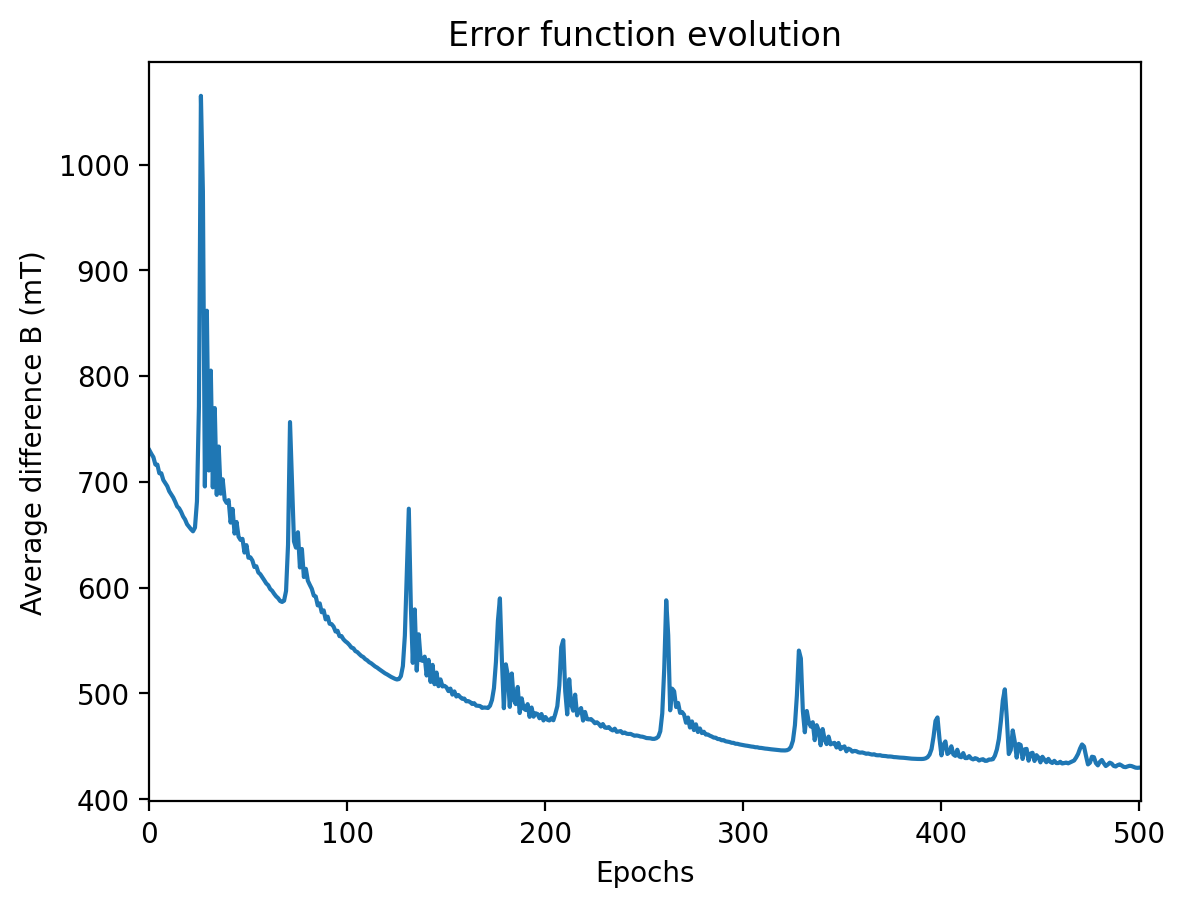

In [36]:
FittingMethod.plot_loss()

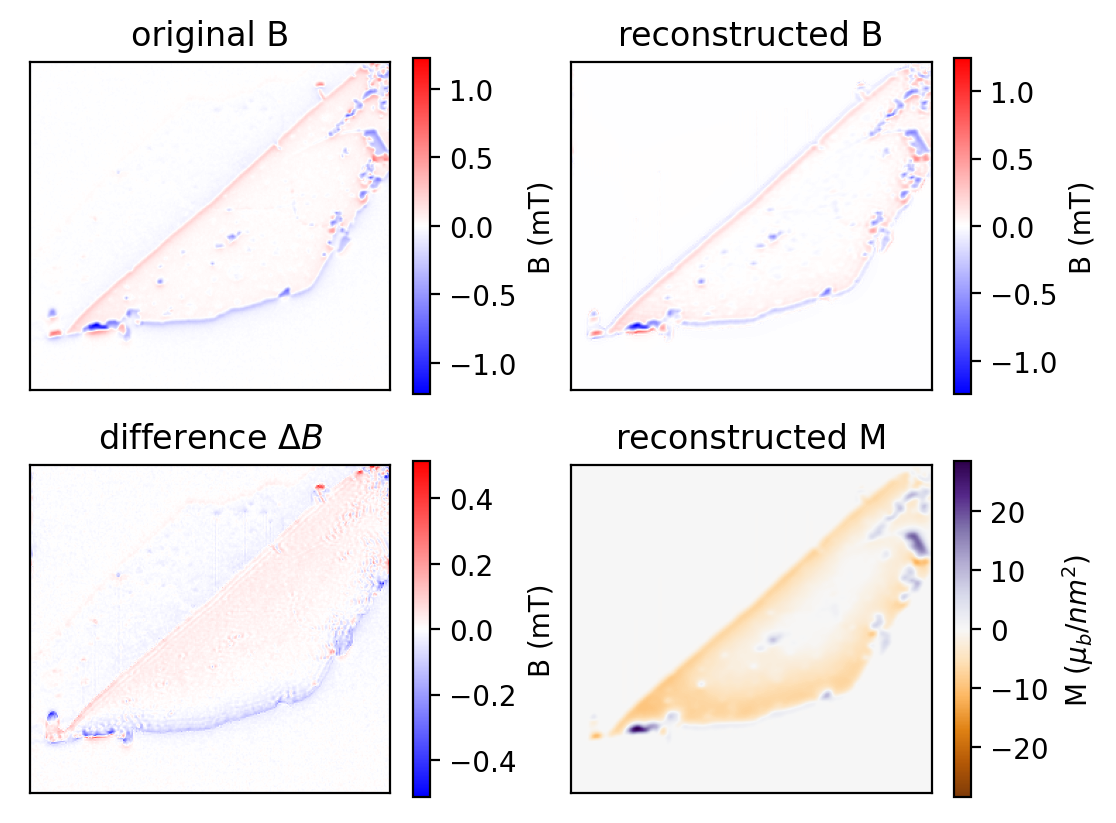

In [37]:
FittingMethod.plot_results()

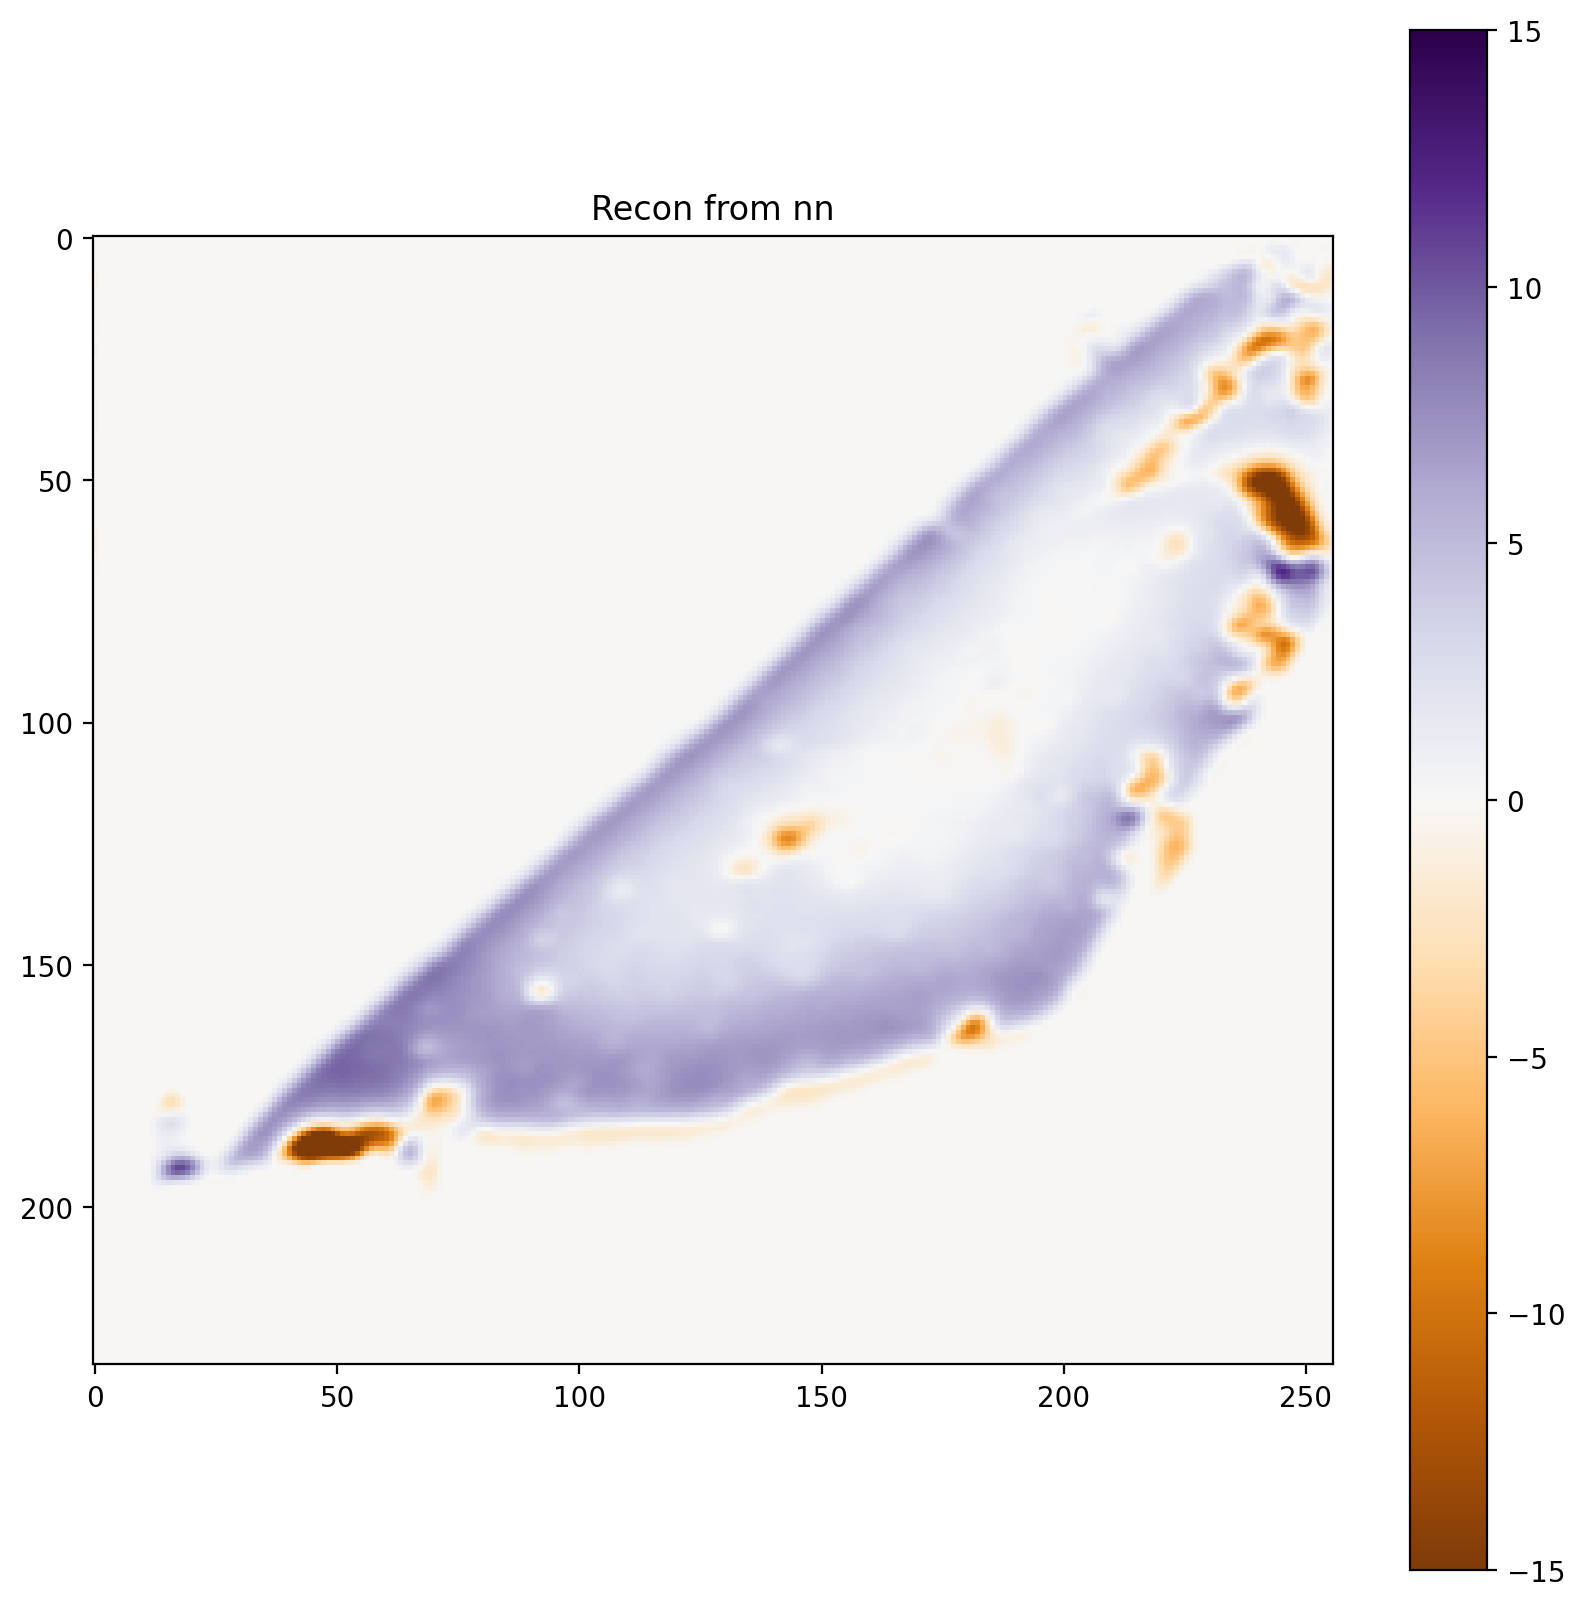

In [38]:
plt.figure(figsize=(10, 10))


plt.imshow(-1*FittingMethod.results["Magnetisation"] , cmap="PuOr", vmin=-15, vmax = 15)
plt.title("Recon from nn")
plt.colorbar()
